In [0]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('./sample_data/mult_2.csv', sep=';')

In [0]:
df

,A,B,RESULT
0,1,6,6
1,1,8,8
2,2,4,8
3,2,3,6
4,2,2,4
5,2,1,2
6,3,5,15
7,3,9,27
8,3,4,12
9,3,9,27


In [0]:
X = df.drop('RESULT',axis=1)
y = df['RESULT']

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=69)
X_test

,A,B
25,7,7
21,5,5
17,5,3
27,7,3
4,2,2
29,8,1
34,10,3
13,4,9


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
X_train.shape

(29, 2)

In [0]:
X_test.shape

(8, 2)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
model = Sequential()

model.add(Dense(2,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [0]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=64,epochs=5000,
          callbacks=[early_stop])

Streaming output truncated to the last 5000 lines.
Epoch 535/5000
29/29 [==============================] - 0s 482us/sample - loss: 2.4158 - val_loss: 4.6078
Epoch 536/5000
29/29 [==============================] - 0s 544us/sample - loss: 2.3650 - val_loss: 4.5410
Epoch 537/5000
29/29 [==============================] - 0s 606us/sample - loss: 2.3138 - val_loss: 4.4763
Epoch 538/5000
29/29 [==============================] - 0s 660us/sample - loss: 2.2623 - val_loss: 4.4139
Epoch 539/5000
29/29 [==============================] - 0s 357us/sample - loss: 2.2138 - val_loss: 4.3520
Epoch 540/5000
29/29 [==============================] - 0s 532us/sample - loss: 2.1670 - val_loss: 4.2907
Epoch 541/5000
29/29 [==============================] - 0s 439us/sample - loss: 2.1210 - val_loss: 4.2306
Epoch 542/5000
29/29 [==============================] - 0s 394us/sample - loss: 2.0732 - val_loss: 4.1730
Epoch 543/5000
29/29 [==============================] - 0s 579us/sample - loss: 2.0275 - val_loss: 4.

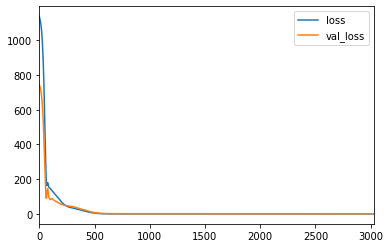

In [0]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [0]:
predictions = model.predict(X_test)

In [0]:
current_mse=mean_absolute_error(y_test,predictions)
current_mse

0.7911569476127625

In [0]:
predictions

array([[48.54114  ],
       [24.714216 ],
       [14.858867 ],
       [18.673761 ],
       [ 3.3278775],
       [ 9.064994 ],
       [30.689474 ],
       [35.30935  ]], dtype=float32)

In [0]:
y_test

25    49
21    25
17    15
27    21
4      4
29     8
34    30
13    36
Name: RESULT, dtype: int64

In [0]:
X_test

array([[0.66666667, 0.54545455],
       [0.44444444, 0.36363636],
       [0.44444444, 0.18181818],
       [0.66666667, 0.18181818],
       [0.11111111, 0.09090909],
       [0.77777778, 0.        ],
       [1.        , 0.18181818],
       [0.33333333, 0.72727273]])

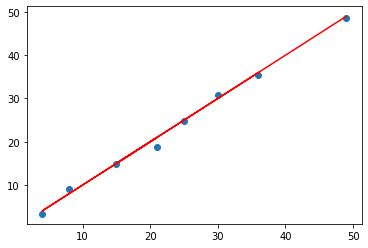

In [0]:
# Our predictions
plt.scatter(y_test,predictions)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [0]:
def compare_with_best_model(curr_model,X_test,y_test):
    best_model=None
    try:
        best_model=tf.keras.models.load_model('./sample_data/best_model.h5') 
        best_pred=best_model.predict(X_test)
        best_mse=mean_absolute_error(y_test,best_pred)
        
        curr_pred= curr_model.predict(X_test)
        curr_mse= mean_absolute_error(y_test,curr_pred)
        if curr_mse<best_mse:
            curr_model.save('./sample_data/best_model.h5')
            best_model=curr_model
            print(f"New best model with mse {curr_mse}")
        else:
            print(f"No new best model, still best mse {best_mse}")
    except:
        print("No best model found")
        best_model=curr_model
        
    return best_model



In [0]:
model = compare_with_best_model(model,X_test,y_test)
 
def predict_function(a,b,best_model,scaler):
    tmp=[[a,b]]
    tmp=scaler.transform(tmp)
    pred=best_model.predict(tmp)
    #tmpDF=pd.DataFrame({'A': [a],'B': [b]})
    #tmpDF=scaler.transform(tmpDF)
    #pred=best_model.predict(tmpDF)
    return pred[0][0]



No new best model, still best mse 0.3222756087779999


## Let's test our best module with 4 multiplications it had never seen

In [0]:
print(predict_function(8,2,model,scaler))
print(predict_function(7,2,model,scaler))
print(predict_function(5,6,model,scaler))
print(predict_function(8,8,model,scaler))
print(predict_function(8,5,model,scaler))

14.560451
13.271186
30.497194
62.43849
39.703285


In [0]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_399 (Dense)            multiple                  6         
_________________________________________________________________
dense_400 (Dense)            multiple                  90        
_________________________________________________________________
dense_401 (Dense)            multiple                  15500     
_________________________________________________________________
dense_402 (Dense)            multiple                  15030     
_________________________________________________________________
dense_403 (Dense)            multiple                  31        
Total params: 30,657
Trainable params: 30,657
Non-trainable params: 0
_________________________________________________________________
